# Lead question: How much lobbying goes on from non European countries in Brussels and how do they compare between them?

07 November 2018

**By Ioannis Antypas**

**Overview**  As countries globally become more aware of the importance of Brussels in coordinating European trade, lobbying efforts intensify. However Western countries far outpace their eastern counterparts, with Silicon Valley leading the way. Why is that?

This story will examine the Transparency Register of the European Union (http://ec.europa.eu/transparencyregister/public/homePage.do) to find the following:

* Total funds spent by European and Non European entities to influence EU decision making
* Top 30 most active countries in EU lobbying by summing the funds spent by all entities with HQ in each respective country
* Funds spent by the entities of each country via Brussels based proxies for the fiscal year 2017
* Interests of all entities per country 

# Background

The European Union is the biggest economic block on the planet, with huge trade relations with every country in the world. This naturally means that there are many who seek to influence its decision making.

When it comes to non-EU lobbying, a lot of attention has been given to the Silicon Valley giants such as Google or Microsoft who are stepping up their efforts to influence European decision making. Asian players on the other hand do not seem to be as active. 

While the EU is for example China’s biggest trading partner, this does not show in China’s lobbying efforts, compared to other, far smaller players? Is it because of China’s more centrally planned economy and the State preferring to deal directly with European national governments? Perhaps, but Japan, another significant EU partner, which boasts a liberal, open economy, also seems to be very small when it comes to lobbying. 

So what makes Western countries such as the USA, Canada, Switzerland and Norway so much more eager to direct resources to lobbying than Asian players?

By mixing data driven work with reporting from Brussels and listening to what stakeholders have to tell us we will be approaching a widely covered issue from an unexpected and fresh angle.

# Data selection

The Transparency Register of the EU offers us a wealth of data to work with. In it, we find rows for every entity wishing to lobby the EU. We looked at the name of each entity, their headquarter location, the interests they have declared, their customers (ie other companies that have mandated them to represent them in Brussels and lobby the EU on their behalf if applicable) and the estimate of how much money they declare they spend in lobbying. Because every entity declares a range of funds, low and high, we calculated the middle ground between them. If they declared an absolute amount, we use this instead.

# Accounting for Belgium proxies

Belgium appears to be the biggest spender in the Transparency Register. But this is mostly because of the big number of companies that set up shop in Brussels and handle the representation of third parties. Each company has to declare their customers, and also to state a range of funds that they are paid, to represent them. We built a script to scrape the TR page of each Brussels based company that has customers, grab the funds they receive from each customer, and then launch queries to wikipedia and google to locate their HQs. If our script does not return any result (for instance Silicon Valley tech giant APPLE INC. is simply registered as APPLE and a wikipedia search of the term returns the fruit instead of the company) we manually identified them and then listed them along with sources that indicate their HQ location. If we could not locate them even manually, we list them as UNCLEAR and drop them.

# Load modules

In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib
import squarify
%matplotlib inline
import glob
from numpy import nan
import numpy as np
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter, FuncFormatter
from statsmodels.graphics.mosaicplot import mosaic
import datetime
from sklearn import preprocessing
from urllib.request import urlopen

import wikipedia as w
from tqdm import tqdm_notebook

import requests
from bs4 import BeautifulSoup
from pywaffle import Waffle

import time
pd.set_option('display.max_columns', 500)



# Open the TR and merge data if it is downloaded in multiple batches

[optional way to read in the TR in case they are downloaded in pieces]

We download the entire transparency register from here: 
http://ec.europa.eu/transparencyregister/public/consultation/search.do?locale=en&reset=
Often the TR website can not handle the request of the entire TR and breaks. In that case we constructed a script
that helps users download smaller portions of them and combine it to one dataframe. 
Simply download as many parts as necessary by using the calendar to slice data and do not alter the ending ".xls"


`path = *your_path*
allFiles = glob.glob(path + "/*.xls")
df = pd.DataFrame()
list_ = []
for file_ in allFiles:
    df_group = pd.read_excel(file_)
    list_.append(df_group)
df = pd.concat(list_)`



In [2]:
df = pd.read_excel('data/TR_18.xls')



In [3]:
df.shape

(11823, 47)

In [4]:
df.head()

,Identification number:,Registration date:,Section,Subsection,(Organisation) name,Legal status:,Website address:,Head office country,Head office address,Head office city,Head office post code,Head office post box,Head office phone,Belgium office address,Belgium office city,Belgium office post code,Belgium office post box,Belgium office phone,Person with legal responsibility,Position:,Person in charge of EU relations,Position:.1,Goals / remit,Level of interest,EU initiatives,Relevant communication,Inter groups,Industry forums,Commission Expert Groups And Other Similar Entities (European Commission),Number of persons involved:,Full time equivalent (FTE),Number of EP accredited persons,Persons accredited for access to European Parliament premises,Fields of interest,Membership,Member organisations,Financial year: Start Date,Financial year: End Date,Estimate of costs (absolute amount),Estimate of costs (as a range),Overall budget/Turnover (absolute amount),Overall budget/Turnover (as a range),Customers,Procurement:,Source,Grants:,Source.1
0,755396231474-56,07/05/2018,I - Professional consultancies/law firms/self-...,Professional consultancies,Miller & Meier Consulting (MMC),GmbH,http://miller-meier.de,Germany,Französische Straße 55,Berlin,10117,NaN,(+49)3028876590,Repräsentanz Avenue des Arts 39,Brüssel,1040,NaN,(+32)25134897,Dominik Meier,Inhaber und Geschäftsführer,Dominik Meier,Inhaber und Geschäftsführer,MMC ist eine deutsche Beratung für Strategie u...,national,Grundsätzliches Interesse an Entwicklungen im ...,Kontaktaufnahme zu und Gespräche mit Stakehold...,NaN,NaN,NaN,2,0.50,NaN,NaN,"General and Institutional Affairs, Trade, Publ...",http://www.degepol.de/,NaN,01/01/2017,01/12/2017,NaN,50000-99999,NaN,0-99999,Canopy Growth Corporation,NaN,NaN,NaN,NaN
1,792681931475-97,07/05/2018,II - In-house lobbyists and trade/business/pro...,Trade and business associations,The Fast Identity Online (FIDO) Alliance (FIDO...,Non-profit standards development organization,https://fidoalliance.org/,United States,"401 Edgewater Place, Suite 600",Wakefield MA,01880,NaN,(+1)4086573436,NaN,NaN,NaN,NaN,NaN,Brett McDowell,Executive Director,Brett McDowell,Executive Director,The mission of the FIDO Alliance is to change ...,global,"Payment Services Directive 2 (PSD2), General D...",NaN,NaN,NaN,NaN,1,0.25,NaN,NaN,"Consumers, Single market, Research and innovat...",NaN,A list of FIDO Alliance members is at https://...,01/01/2017,01/12/2017,NaN,50000-99999,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,051844129600-85,15/01/2018,II - In-house lobbyists and trade/business/pro...,Companies & groups,Albemarle Europe,SPRL,http://www.albemarle.com,Belgium,Parc Scientifique Einstein Rue du Bosquet 9,Louvain-la-Neuve,1348,NaN,(+32)10481711,NaN,NaN,NaN,NaN,NaN,Silvio Ghyoot,Managing Director,Adam McCarthy,"Director Government & Regulatory Affairs, Europe","Albemarle Corporation (NYSE: ALB), headquarter...","European, global, national, regional/local",- Chemical Legislation (REACH) \n- RoHS \n- Tr...,NaN,NaN,NaN,NaN,1,0.50,NaN,NaN,"Economy, finance and the euro, Budget, Trade, ...",Albemarle is a member of a number of associati...,- The International Bromine Council (BSEF) \n-...,01/01/2017,01/12/2017,NaN,100000-199999,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,934996421910-13,25/05/2016,III - Non-governmental organisations,"Non-governmental organisations, platforms and ...",KENUP Foundation,Lawful Purpose Foundation,http://www.kenup.eu,Malta,Chaplain’s House Triq il-Marina Villa Bighi,Kalkara,KKR 1320,NaN,(+356)21695955,NaN,NaN,NaN,NaN,NaN,Holm Keller,Chairman of the Board,Holm Keller,Chairman of the Board,The support of activities and projects initiat...,"European, global, national, regional/local",Horizon 2020; Investment Plan; European Fund f...,OPINION For the Committee of Legal Affairs \no...,NaN,NaN,NaN,10,6.00,NaN,NaN,"Education and training, Business and Industry,...",Open Music Initiative (http://open-music.org/a...,www.kenup.eu,01/01/2016,01/12/2016,NaN,100000-199999,200000.0,NaN,

# Calculate % of EU and non-EU entities 

In [5]:
# creating a list of EU countries and making a column seperating EU from non-EU 
eu = ['Belgium','Germany','United Kingdom','France','Italy','Spain','Netherlands','Sweden','Austria','Finland','Poland','Denmark','Portugal','Ireland','Greece','Romania','Czech Republic','Hungary','Luxembourg','Bulgaria','Slovenia','Slovakia','Croatia','Estonia','Lithuania','Latvia','Malta','Cyprus']
df['European_Union'] = df['Head office country'].isin(eu)

# The total number of observations is 11823, caclculating percentage eu and non eu 
df['European_Union'].value_counts(normalize=True).mul(100).astype(str)+'%'


True     90.65381036961854%
False     9.34618963038146%
Name: European_Union, dtype: object

# There are less non-eu entities. What % of the spending do they account for?

In [8]:
# Each entity lists their planned lobbying related expenditure as a range - low to high.
# We will calculate the amount in the middle as in general entities are found to both over and under report their 
# lobby related spending 

# First we split them to two columns

df["low"] = df["Estimate of costs (as a range)"].str.split("-", 1, expand = True)[0]
df["high"] = df["Estimate of costs (as a range)"].str.split("-", 1, expand = True)[1]

# Working around NaNs
df['high'].replace('None', np.nan, inplace=True)
df['high'].fillna(value=nan, inplace=True)

# Replacing string symbols to work them as numerics
df['high'] = df['high'].str.replace(">","")
df['low'] = df['low'].str.replace(">","")

# Finding the middle amount

df[['low','high']] = df[['low','high']].apply(pd.to_numeric)
df['average'] = (df['low'] + df['high']) /2

# Now to account for instances where the entities declared an absolute amount and not estimate

# dealing with nans
df['Estimate of costs (absolute amount)'].replace(nan, np.nan, inplace=True)
df['Estimate of costs (absolute amount)'].fillna(value=nan, inplace=True)

# Iterating over instances where the absolute amount is reported as higer than 0 and replacing the average value 
# previously calculated
counter = 0

# grabs all the interest the row of data
for amount in tqdm_notebook(df['Estimate of costs (absolute amount)']):
    if amount > 0:
        df['average'].iloc[counter] = amount
    counter += 1

# Grouping them by average and finding the total amounts allocated to lobbying and assining them to new df
df_grouped = df.groupby('Head office country')['average'].sum().sort_values(ascending=False).round().to_frame().reset_index()

# Assigning eu and non-eu column
df_grouped['European_Union'] = df_grouped['Head office country'].isin(eu)

# Turning boolean column to string to allow for grouping
booleanDictionary = {True: 'TRUE', False: 'FALSE'}
df_grouped['European_Union'] = df_grouped['European_Union'].replace(booleanDictionary)

/Users/gcg/.virtualenvs/ddj/lib/python3.5/site-packages/pandas/core/indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [11]:
# Getting the total amount spent
sum_midpoints = df_grouped['average'].sum()
print('Total lobbying volume:', sum_midpoints/1000000000, "billion euros")

Total lobbying volume: 2.068824529 billion euros


In [12]:
# Calculating percentage spending

df_grouped.groupby('European_Union')['average'].sum().mul(100).div(sum_midpoints).astype(str)+'%'

European_Union
FALSE    11.246444139584154%
TRUE      88.75355586041584%
Name: average, dtype: object

Non-EU Entities account for 9% of the total but spend 11% of the total

In [13]:
# Creating a small df to visualize
df_bars = pd.DataFrame({'type':    [ 'eu','non-eu'],'entity population': [91, 9],'spending': [89, 11]})

df_bars

,entity population,spending,type
0,91,89,eu
1,9,11,non-eu


(array([0, 1]), <a list of 2 Text xticklabel objects>)

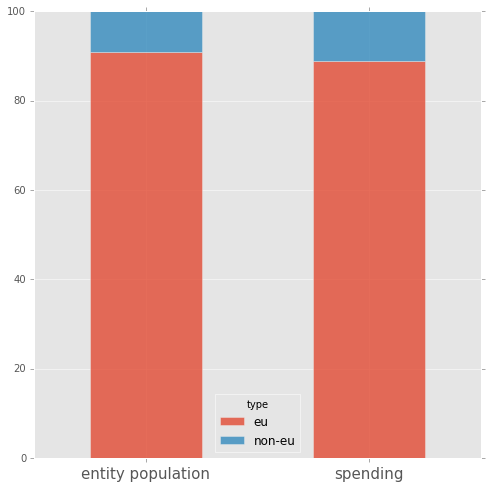

In [14]:
matplotlib.style.use('ggplot')

df_bars.pivot_table(values = ['entity population','spending'],
                    columns = ['type']).plot(kind='bar',stacked=True, figsize=(8,8),rot=0, alpha=0.8)

plt.xticks(size = 15)
# plt.savefig('chart_1.pdf')

# Which non-EU countries make the top 30



In [15]:
# export for D3 purposes
numbers = [0,1,2,3,4,0,1,2,3,4]

df_export = df_grouped.loc[df_grouped['Head office country'].isin(['Belgium', 'Germany','Italy','United Kingdom','France','United States','Switzerland','Norway','Japan','China'])]
df_export['y_scale'] = numbers

/Users/gcg/.virtualenvs/ddj/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [16]:
df_export.to_csv('non-eu-countries-export.csv')

In [17]:
# Creating a column dummy to handle different colors
df_grouped['dummy'] = df_grouped['European_Union'] == 'FALSE'
colored = []
colored.append(df_grouped.dummy.head(30).map({True: 'brown', False: '#529ECD'}))


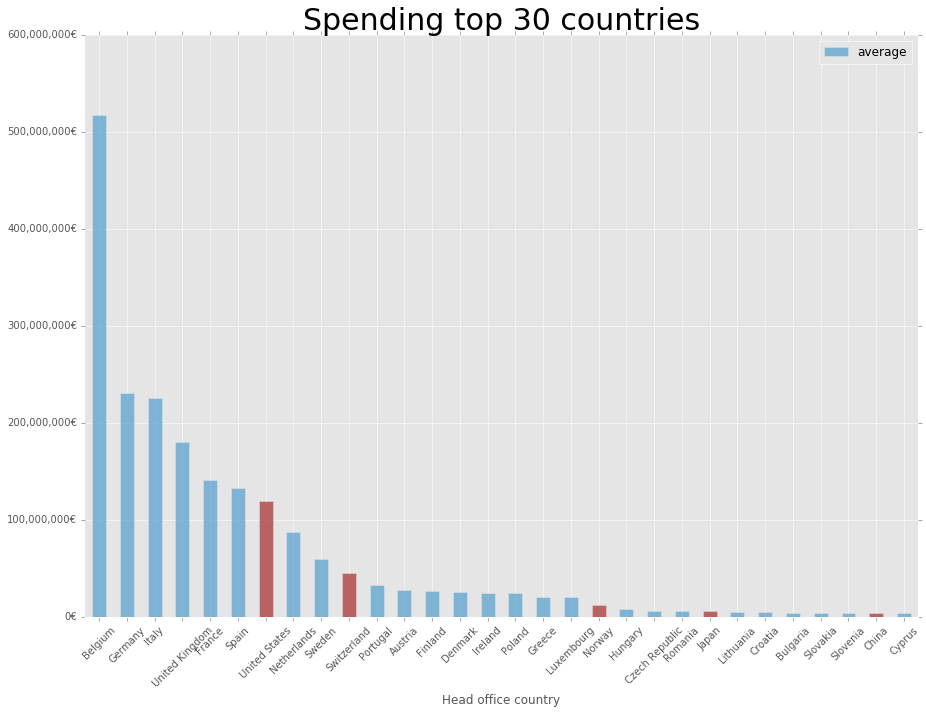

In [18]:
# visualizing the second chart
ax = df_grouped.sort_values(by='average',ascending=False).head(30).plot(kind='bar', x='Head office country',
                                                                        y='average', align='center',
                                                                        color= [i for i in colored[0]], alpha=0.7,
                                                                        figsize=(13,10))
ax.tick_params(axis = 'both', which = 'major', labelsize = 10)

ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)                           


ax.yaxis.set_major_formatter(FormatStrFormatter('€'))
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',') + '€')) 
plt.xticks(rotation='45')


ax.set_title('Spending top 30 countries', fontsize=30)



plt.tight_layout()
# plt.savefig('chart_2.pdf')

# Accounting for Belgium

How do we account for Belgian based entities. They have the biggest share of the spending, entities, and persons involved!

In [19]:
# We grab the entities that spend the most. Isolate the top 100

df_belg = df[df['Head office country'] == 'Belgium'].sort_values(by='average',ascending=False).head(100)
df_belg = df_belg[['Identification number:','Section','Registration date:','(Organisation) name','Full time equivalent (FTE)','Customers','average']]

# We drop any rows where there is a NaN. Due to the nature of data in the Register, NaNs appear only in the Customer column
df_belg.dropna(inplace=True)

The range of funds paid by each customer to the entity representing them in Brussels is only available in the TR webpage.

We make a script that first enters the page and get the range of funds and then queries wikipedia with their name to locate as many HQ locations as possible

In [20]:
#create a new df
df_business = pd.DataFrame(columns=['Customer', 'Representative'])

counter_of_rows = 0

#iterate over the column customers
for customer in df_belg['Customers']:
    try:
        df_business = df_business.drop(['level_0','index'], 1)
    except:
        pass


    #create a list with customer names from particular row
    customer_list = df_belg['Customers'].iloc[counter_of_rows].split(',')

    # Remove extra spaces in customer_list
    customer_list = [i.strip() for i in customer_list]
    customer_dict = {}
    
    # iterate over each list to create a dictionary of the customer name and the company who represents them
    for key in customer_list:
        customer_dict.update({key : df_belg['(Organisation) name'].iloc[counter_of_rows]})
    df_temporary = pd.DataFrame(list(customer_dict.items()), columns=['Customer', 'Representative'])
        
        
    # initializing another loop to scrape amount paid to representative for lobbying from the TR
    
    # set a url based on the entity id
    url = "http://ec.europa.eu/transparencyregister/public/consultation/displaylobbyist.do?id=" + str(df_belg['Identification number:'].iloc[counter_of_rows])
    r = requests.get(url)
    soup = BeautifulSoup(r.content, "html")
    
    # get the divs which associate the entity's clients with how much they pay said entity
    spending_divs = soup.select("div.panel.panel-default > .panel-body")

    counter_spending = 0
    # Create a new column named spending
    df_temporary['spending'] = ''
    
    # First get the name of each entity's customer
    for spending_of_customer in customer_list:
        
        # Search each div for a li element with the same string
        for div in spending_divs:
            if div.find("li", string=spending_of_customer) != None:
                
                # Store the div
                found_div = div
        
        # Locate the right part of "spending" to add the result thanks to counter
        df_temporary['spending'].loc[counter_spending] = found_div.find("label").get_text().strip()
        
        counter_spending += 1
        continue


    # drop duplicate columns
    try:
        df_business = df_business.drop(['level_0','index'], 1)
    except:
        pass
    #concat to main df
    df_business = pd.concat([df_business, df_temporary], axis =0).reset_index()        
    counter_of_rows += 1

df_business.head()


/Users/gcg/.virtualenvs/ddj/lib/python3.5/site-packages/bs4/__init__.py:166: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

To get rid of this warning, change this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


,index,Customer,Representative,spending
0,0,European Commission,Business and Strategies in Europe (B&S Europe),"With the revenue of 1,000,000 € or more:"
1,1,Belgian Development Agency,Business and Strategies in Europe (B&S Europe),"With the revenue of 1,000,000 € or more:"
2,2,NIS,Fleishman-Hillard,"With the revenue of 100,000 € - 199,999 €:"
3,3,UNPRI,Fleishman-Hillard,"With the revenue of 100,000 € - 199,999 €:"
4,4,COSMETICS EUROPE,Fleishman-Hillard,"With the revenue of 100,000 € - 199,999 €:"


In [21]:
# creates a new columns where we will store the HQ values
df_business['HQ'] = 'No link found'

# list to save the HQ strings
hqs = []
wikipedia_counter = 0


for page in df_business['Customer']:
    try: 
        # this launches a search using the wikipedia module and gives us the first result
        
        if w.page(w.search(str(page))[0]):
            s = w.page(w.search(str(page))[0])
        else:
            pass
        url = s.url
        print(url)
        # we use requests to scrape the page and then as company pages in wikipedia are standardized we locate the HQ
        # th which is always in the same place
        r = requests.get(url)
        soup = BeautifulSoup(r.content, "html")
        if soup.find_all('table',{'class' : 'infobox'})[0]:
            box = soup.find_all('table',{'class' : 'infobox'})[0]
        else:
            pass
        if box.find_all('tr'):
            rows = box.find_all('tr')
        elif soup.find_all('tr'):
            rows = soup.find_all('tr')
        else:
            pass

        for i in rows:
            if i.find('th', string='Headquarters') != None: 
                row = i
                print(row.findNext('td').get_text())
                df_business['HQ'].loc[wikipedia_counter] = row.findNext('td').get_text().strip()
                row = ''

    except IndexError:
        print("Nothing came up in search " + url)
        pass
            
    except w.exceptions.DisambiguationError as e:
        print("Error: {0}".format(e))
        pass


    wikipedia_counter +=1
    print(wikipedia_counter)
                

https://en.wikipedia.org/wiki/European_Commission


/Users/gcg/.virtualenvs/ddj/lib/python3.5/site-packages/bs4/__init__.py:166: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

To get rid of this warning, change this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


1
https://en.wikipedia.org/wiki/List_of_development_aid_agencies
Nothing came up in search https://en.wikipedia.org/wiki/List_of_development_aid_agencies
2
https://en.wikipedia.org/wiki/Ni%C5%A1
3
https://en.wikipedia.org/wiki/Principles_for_Responsible_Investment
Nothing came up in search https://en.wikipedia.org/wiki/Principles_for_Responsible_Investment
4
https://en.wikipedia.org/wiki/Cosmetics
Nothing came up in search https://en.wikipedia.org/wiki/Cosmetics
5
https://en.wikipedia.org/wiki/Thomson_Reuters
Toronto, ON, Canada
6


/Users/gcg/.virtualenvs/ddj/lib/python3.5/site-packages/pandas/core/indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


https://en.wikipedia.org/wiki/European_DataWarehouse
Frankfurt, Germany
7
https://en.wikipedia.org/wiki/PIMCO
Newport Beach, California, U.S.
8
https://en.wikipedia.org/wiki/Bisphenol_A
9
https://en.wikipedia.org/wiki/Bayer
Leverkusen, Germany
10
https://en.wikipedia.org/wiki/Niklas_Zennstr%C3%B6m
11
https://en.wikipedia.org/wiki/Umicore
Brussels, Belgium
12
https://en.wikipedia.org/wiki/Barclays
London, United Kingdom
13
https://en.wikipedia.org/wiki/Nykredit
Copenhagen, Denmark
14
https://en.wikipedia.org/wiki/Hudson_River_Trading
Nothing came up in search https://en.wikipedia.org/wiki/Hudson_River_Trading
15
https://en.wikipedia.org/wiki/HSBC
8 Canada Square, London, London, United Kingdom
16
https://en.wikipedia.org/wiki/List_of_International_Organization_for_Standardization_standards
Nothing came up in search https://en.wikipedia.org/wiki/List_of_International_Organization_for_Standardization_standards
17
https://en.wikipedia.org/wiki/Registered_Investment_Adviser
Nothing came up 

KeyboardInterrupt: 

We are dealing with multiple hundred companies, each with different names that results in high variance when we query wikipedia with their names. This leads to a lot of inconsistencies and missing values. 

We make a second attempt to find their HQs by creating a df with the rows that the first script failed to find a company HQ and then perform seraches in google using the formula of the company name + WIKIPEDIA to try to see if google can help us find the right wikipedia page for them.

In [ ]:
################################
#Takes a long time to fully run#
################################


df_business_empty = df_business[df_business['HQ'] == 'No link found']
# eliminating spaces and replacing them with %20 that will help us query to google
df_business_empty['Customer'] = df_business_empty['Customer'].str.replace('\s', '%20')

wikipedia_counter = 0

# iterate over company names
for company in df_business_empty['Customer']:
    
    # query a google search 
    term = str(company+ '%20WIKIPEDIA')
    url = 'https://www.google.com/search?q={0}&rlz=1C1TSNO_enUS566US566'.format(term)
    print(str(url) + '   ******   ' + str(wikipedia_counter))
    r = requests.get(url)
    
    soup = BeautifulSoup(r.text, "html.parser")
    # grab resulting links
    links = soup.find_all('h3', {'class': 'r'})
    list_of_links = []
    
    # iterate over them
    for h3 in links:
        for link in h3.find_all('a'):
            list_of_links.append(link.get('href'))
            
    # informs us of how many lists we found      
    print(str(len(list_of_links))+ '  Links found')
    list_of_links2 =[]
    
    # we parse found links in a list
    for link in list_of_links:
        link = re.sub('/url\?q=(.+?)(&sa.*)', r'\1', link)
        list_of_links2.append(link)
        if len(list_of_links2 ) == len(list_of_links):
            print('Done parsing links')

    try: 
        request = requests.get(list_of_links2[0], verify=False)
    except requests.packages.urllib3.exceptions.MaxRetryError as e:
        print(e)
        pass
    
    # We get the html of each link, and if it matches with a wikipedia page we continue else we return and grab the next
    soup = BeautifulSoup(request.content, "html.parser")
    

    try:
        soup.find_all('table',{'class' : 'infobox'})[0]
        box = soup.find_all('table',{'class' : 'infobox'})[0]
        
    except IndexError:
        print('IndexError')
        link_counter = 1
        print('link_counter ', link_counter)
        try:
            for link in list_of_links2:
                print(link)
                try:
                    request = requests.get(list_of_links2[link_counter], verify=False)
                except MaxRetryError:
                    print('MaxRetryError!')
                    pass
                        
                soup = BeautifulSoup(request.content, "html.parser")
                try:
                    soup.find_all('table',{'class' : 'infobox'})[0]
                    box = soup.find_all('table',{'class' : 'infobox'})[0]
                    break
                    
                except IndexError:
                    link_counter +=1
        except:
            print("Here is a mistake")
    # If we find it we repeat the process of the previous script and get the HQ
    if box.find_all('tr'):
            rows = box.find_all('tr')
            print('lets begin')
    else:
        pass

    for i in rows:
        if i.find('th', string='Headquarters') != None: 
            row = i
            print(row.findNext('td').get_text())
            df_business_empty['HQ'].loc[wikipedia_counter] = row.findNext('td').get_text().strip()
            row = ''
        
            
            
    wikipedia_counter += 1
    print('wikipedia_counter', wikipedia_counter)

# Once the script is over we clean up the customer names
df_business_empty.Customer = df_business_empty.Customer.str.replace('%20', ' ')

We merge the two dfs replacing the rows of the original that the first script failed to find an HQ with the rows of the second where it was succesfull.

Then we export it and manually locate all missing HQs. 

A detailed list of all manually found HQs exists on the very last cell.

In [ ]:
df_test_business = pd.concat([df_business,df_business_empty]).drop_duplicates(['Customer','Representative'],keep='last').sort_values('index')
df_test_business.to_csv('df_test_business.csv')


In [22]:
# Opening the cleaned df
business = pd.read_csv('data/cleaned_df_business.csv')

# replace a string named Tokyo with Japan
business.HQ = business.HQ.str.replace('Tokyo', 'Japan')

# Repeat the process of calculating the average spending based on high and low estimates
business.spending = business.spending.str.replace('[A-Za-z]', '')
business["low"] = business.spending.str.split("-", 1, expand = True)[0]
business["high"] = business.spending.str.split("-", 1, expand = True)[1]

business.low = business.low.str.replace('\W', '')
business.high = business.high.str.replace('\W', '')

business[['low','high']] = business[['low','high']].apply(pd.to_numeric)
business['average'] = (business['low'] + business['high']) /2

business.average = business.average.astype(str)

# If there is only one amount specified, use this
counter_spending = 0
for amount in tqdm_notebook(business['average'].astype(str)):
    if amount == 'nan':
        business.average.loc[counter_spending] = business.low.loc[counter_spending]
    counter_spending +=1
        
business.average = business.average.astype(float).round().astype(int)



/Users/gcg/.virtualenvs/ddj/lib/python3.5/site-packages/pandas/core/indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


# The US champions spending via Brussels based institutions

Belgium is high due to most pan-european associations setting up base in Brussels opting to use Brussels based companies to represent them

Silicon Valley is on the top 5! We will retain it as a seperate finding for our visualization.

In [23]:
business.groupby('HQ')['average'].sum().sort_values(ascending=False)

HQ
USA               11934989
Belgium           11652480
UK                 4052494
France             3232489
Silicon Valley     2662500
Germany            1902495
Switzerland        1644997
Sweden             1510000
Netherlands        1362497
Japan              1189997
UNCLEAR             924999
Italy               692498
Canada              384999
Spain               335000
India               300000
Morocco             287500
South Korea         225000
China               225000
Poland              187500
Moldova             150000
Austria             150000
Thailand            150000
Serbia              150000
Singapore           150000
South Africa        150000
Denmark             132498
Israel              102499
Greece               84999
Ukraine              75000
UAE                  75000
Portugal             75000
Russia               75000
Tunisia              75000
Ireland              75000
Taiwan               75000
Luxembourg           55000
Hungary              3750

In [24]:
# again figuring out EU and non EU states
eu = ['Belgium','Germany','United Kingdom','France','Italy','Spain','Netherlands','Sweden','Austria','Finland','Poland','Denmark','Portugal','Ireland','Greece','Romania','Czech Republic','Hungary','Luxembourg','Bulgaria','Slovenia','Slovakia','Croatia','Estonia','Lithuania','Latvia','Malta','Cyprus']
business['European_Union'] = business['HQ'].isin(eu)



(0.0, 100.0, 0.0, 100.0)

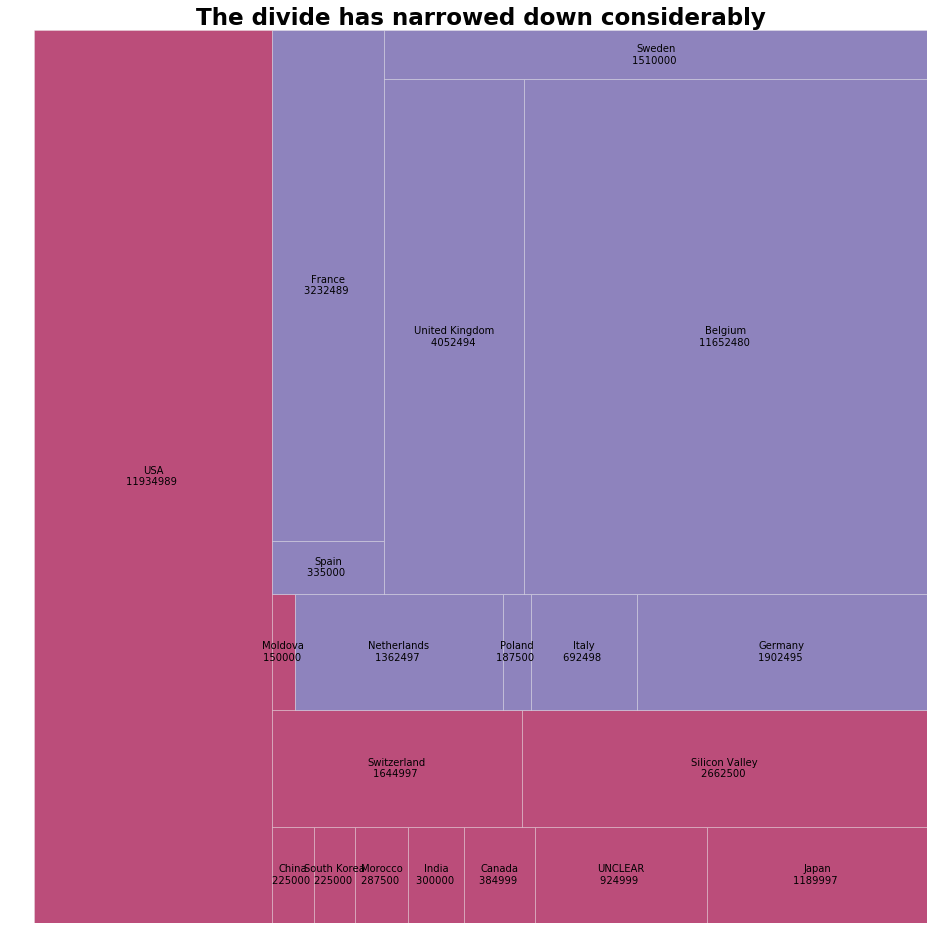

In [26]:
# calculating sums, changing a string and finding EU countries
df_business_grouped =  business.groupby('HQ')['average'].sum().sort_values(ascending=False).head(20).to_frame().reset_index()
df_business_grouped.HQ = df_business_grouped.HQ.str.replace('UK', 'United Kingdom')
df_business_grouped['European_Union'] = df_business_grouped['HQ'].isin(eu)

# then visualizing

df_business_grouped = df_business_grouped.sort_values('European_Union')

plt.style.use('ggplot')

norm = matplotlib.colors.Normalize(vmin=min(df_business_grouped.European_Union), vmax=max(df_business_grouped.European_Union))
colors = [matplotlib.cm.Spectral(norm(value)) for value in df_business_grouped.European_Union]
labels = ["%s\n%d " % (label) for label in zip(df_business_grouped.HQ, df_business_grouped.average)]

fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 16)


squarify.plot(label=labels, sizes=df_business_grouped.average, color = colors, alpha=.7)


plt.title("The divide has narrowed down considerably",fontsize=23,fontweight="bold")

plt.axis('off')

# plt.savefig('chart_3.pdf')



# Brexit heading

In [27]:
# Opening a previous version of the TR (downloaded on August 2017) with entities that include finance in their interests. 
# legacy versions of the TR can be found here https://data.europa.eu/euodp/en/data/dataset/transparency-register
df_finance = pd.read_excel('data/TR_Finance_17.xls')


In [28]:
df_finance.head()

,Identification number:,Registration date:,Section,Subsection,(Organisation) name,Legal status:,Website address:,Head office country,Head office address,Head office city,Head office post code,Head office post box,Head office phone,Belgium office address,Belgium office city,Belgium office post code,Belgium office post box,Belgium office phone,Person with legal responsibility,Position:,Person in charge of EU relations,Position:.1,Goals / remit,Level of interest,EU initiatives,Relevant communication,High-level groups,Consultative committees,Expert groups,Inter groups,Industry forums,Number of persons involved:,Full time equivalent (FTE),Number of EP accredited persons,Persons accredited for access to European Parliament premises,Fields of interest,Membership,Member organisations,Financial year: Start Date,Financial year: End Date,Estimate of costs (absolute amount),Estimate of costs (as a range),Turnover (absolute amount),Turnover (as a range),Customers,Procurement:,Source,Grants:,Source.1
0,293502227711-32,11/07/2017,II - In-house lobbyists and trade/business/pro...,Companies & groups,Planet Labs Netherlands B.V. (Planet),B.V.,http://planet.com,Netherlands,Herengracht 338,Amsterdam,1016CG,NaN,(+31)615666502,NaN,NaN,NaN,NaN,NaN,Wofgang Out,Director B,Agnieszka Lukaszczyk,Director EU Policy,"Planet is designing, building and launching sa...",global,"Copernicus Programme, Space Surveillance and T...","Earth monitoring, base maps, imagery, high res...",Copernicus Committee,Copernicus User Forum,NaN,Sky and Space Intergroup,All relevant events and forums,8,5.00,1.0,LUKASZCZYK Agnieszka,"Economic and Financial Affairs, Agriculture an...",European Association of Remote Sensing Compani...,NaN,01/01/2016,01/12/2016,NaN,200000-299999,0.0,NaN,NaN,1000000.0,The Copernicus Programme,NaN,NaN
1,730832627596-38,26/06/2017,I - Professional consultancies/law firms/self-...,Professional consultancies,Deloitte Tax & Consulting,Société à responsabilité limitée,https://www2.deloitte.com/lu/,Luxembourg,Rue de Neudrof 560,Luxembourg,2220,NaN,(+352)451451,NaN,NaN,NaN,NaN,NaN,Petra Hazenberg,Partner,Petra Hazenberg,Partner,La Société a pour objet l'exécution de tous ma...,"European, global, national, regional/local",CHAFEA - Consumer study on pre-contractual inf...,NaN,DG Connect - 2nd survey of schools: ICT in edu...,NaN,NaN,NaN,NaN,8,6.00,NaN,NaN,"General and Institutional Affairs, Economic an...",NaN,NaN,01/05/2015,01/05/2016,NaN,300000-399999,NaN,500000-999999,"Chafea, DG Connect, DG Fisma",NaN,NaN,NaN,NaN
2,539787027361-33,01/06/2017,II - In-house lobbyists and trade/business/pro...,Other organisations,ATM - Associação de Investidores e Analistas T...,non-profit association,http://www.associacaodeinvestidores.org,Portugal,Rua Capitão Henrique Galvão 130 7 DF,Porto,4050-300,NaN,(+351)916186786,NaN,NaN,NaN,NaN,NaN,Octávio Viana,President of the board of directors,Octávio Viana,President of the board of directors,ATM is a portuguese investor's association wit...,national,"Coporate Govenance, Take over Directive, Twin-...",We are the oldest portuguese investor associat...,NaN,NaN,NaN,NaN,NaN,31,11.00,NaN,NaN,"Economic and Financial Affairs, Competition, T...",ATM - asssociação de investidores e analistas ...,NaN,01/01/2016,01/12/2016,NaN,0-9999,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,090447527374-95,02/06/2017,I - Professional consultancies/law firms/self-...,Professional consultancies,Soros Gabinete S.L.U. (Soros Gabinete),Limited Liability Company,http://www.soros.es/,Spain,"Calle Ferraz 94, 2º-Derecha",Madrid,28008,NaN,(+34)91 297 97 37,NaN,NaN,NaN,NaN,NaN,Diego Soro Sánchez,Executive Partner,Sharam Yalda,Senior Partner,Strategic consulting and innovation management...,European,Digital Agenda \nClimate Change \nEnvironment ...,Public relations mainly developed in colaborat...,NaN,NaN,NaN,NaN,NaN,1,0.25,NaN,NaN,"Economic and Financial Affairs, Education, Emp...",NaN,NaN,01/01/2015,01/12/2015,8000.0,NaN,450000.0,NaN,NaN,NaN,NaN,NaN,NaN
4,157385327522-40,18/06/20

In [29]:
# slicing to isolate full time employees registration date and head office location, then extracting the year
df_finance = df_finance[['Registration date:', 'Head office country', 'Full time equivalent (FTE)']]
df_finance['date'] = pd.to_datetime(df_finance['Registration date:'], format="%d/%m/%Y")
df_finance['year'] = df_finance['date'].apply(lambda x: x.strftime('%Y')) 


In [30]:
# grouping and pivoting to get the number of full time employees, country, year

df_finance = df_finance.groupby(['year', 'Head office country'])['Full time equivalent (FTE)'].sum().reset_index()
pd.DataFrame(df_finance)
df_finance['Full time equivalent (FTE)'] = df_finance['Full time equivalent (FTE)'].astype(np.int64)
df_finance = df_finance.pivot_table(index=('year'), columns='Head office country', values='Full time equivalent (FTE)')
df_finance.head(15)

Head office country,Austria,Belgium,Bulgaria,China,Croatia,Cyprus,Czech Republic,Denmark,Estonia,Finland,France,Germany,Greece,Hungary,Ireland,Italy,Latvia,Lithuania,Luxembourg,Malta,Netherlands,Poland,Portugal,Romania,"Russia, Federation Of",Slovakia,Slovenia,Spain,Sweden,Turkey,United Kingdom,United States
year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2008,65.0,368.0,NaN,NaN,NaN,NaN,1.0,17.0,NaN,9.0,51.0,290.0,NaN,NaN,3.0,16.0,0.0,59.0,10.0,NaN,16.0,0.0,NaN,NaN,NaN,NaN,NaN,18.0,37.0,NaN,62.0,20.0
2009,17.0,649.0,7.0,NaN,NaN,6.0,0.0,5.0,NaN,1.0,108.0,178.0,16.0,NaN,22.0,27.0,NaN,NaN,16.0,NaN,27.0,14.0,NaN,NaN,NaN,NaN,NaN,9.0,7.0,NaN,140.0,61.0
2010,34.0,317.0,17.0,NaN,6.0,NaN,4.0,3.0,NaN,9.0,33.0,125.0,NaN,6.0,4.0,17.0,NaN,NaN,1.0,NaN,27.0,5.0,13.0,4.0,NaN,NaN,NaN,33.0,14.0,NaN,132.0,57.0
2011,23.0,592.0,NaN,NaN,27.0,NaN,1.0,6.0,NaN,56.0,105.0,209.0,1.0,114.0,9.0,193.0,NaN,NaN,44.0,NaN,31.0,13.0,18.0,1.0,2.0,NaN,NaN,16.0,54.0,6.0,158.0,16.0
2012,5.0,183.0,2.0,NaN,2.0,1.0,1.0,12.0,NaN,1.0,70.0,144.0,4.0,3.0,4.0,91.0,NaN,NaN,NaN,1.0,29.0,4.0,37.0,20.0,NaN,NaN,NaN,158.0,10.0,NaN,104.0,11.0
2013,60.0,120.0,NaN,NaN,NaN,NaN,2.0,14.0,NaN,12.0,51.0,82.0,41.0,8.0,0.0,131.0,NaN,NaN,NaN,NaN,89.0,9.0,3.0,24.0,NaN,NaN,NaN,2142.0,2.0,2.0,79.0,11.0
2014,8.0,147.0,NaN,0.0,0.0,NaN,7.0,4.0,NaN,7.0,101.0,60.0,12.0,0.0,19.0,573.0,NaN,2.0,7.0,0.0,12.0,22.0,81.0,210.0,8.0,3.0,0.0,71.0,22.0,1.0,69.0,23.0
2015,19.0,222.0,15.0,2.0,9.0,3.0,5.0,21.0,0.0,28.0,125.0,138.0,87.0,3.0,27.0,126.0,10.0,1.0,10.0,4.0,140.0,45.0,36.0,70.0,1.0,7.0,1.0,201.0,32.0,NaN,342.0,81.0
2016,28.0,276.0,19.0,1.0,12.0,4.0,19.0,17.0,3.0,20.0,116.0,259.0,38.0,37.0,25.0,211.0,2.0,7.0,19.0,2.0,116.0,73.0,101.0,15.0,0.0,9.0,7.0,127.0,61.0,7.0,163.0,53.0


In [31]:
# Now calculating the total number of full time lobbyists per year

df_financeFrance = df_finance['France']
df_financeGermany = df_finance['Germany']
df_financeUK = df_finance['United Kingdom']

df_finance.loc['2009'] = df_finance.loc['2009'] + df_finance.loc['2008']   
df_finance.loc['2010'] = df_finance.loc['2010'] + df_finance.loc['2009']   
df_finance.loc['2011'] = df_finance.loc['2011'] + df_finance.loc['2010']
df_finance.loc['2012'] = df_finance.loc['2012'] + df_finance.loc['2011']
df_finance.loc['2013'] = df_finance.loc['2013'] + df_finance.loc['2012']
df_finance.loc['2014'] = df_finance.loc['2014'] + df_finance.loc['2013']
df_finance.loc['2015'] = df_finance.loc['2015'] + df_finance.loc['2014']
df_finance.loc['2016'] = df_finance.loc['2016'] + df_finance.loc['2015']
df_finance.loc['2017'] = df_finance.loc['2017'] + df_finance.loc['2016']

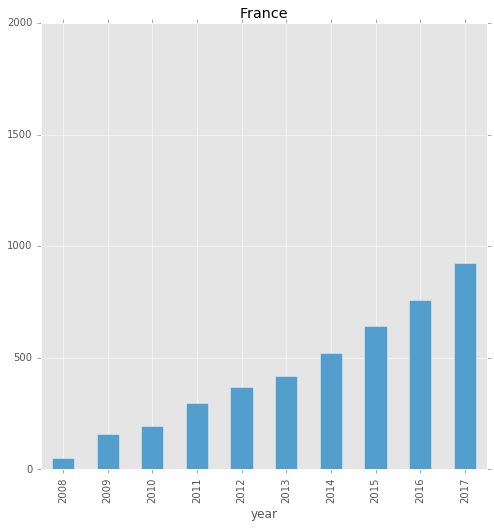

In [34]:
# visualizations

ax = df_financeFrance.plot(kind='bar', figsize =(8,8), color='#529ECD')
ax.set_ylim([0,2000])
plt.title('France')
# plt.savefig("France.pdf")



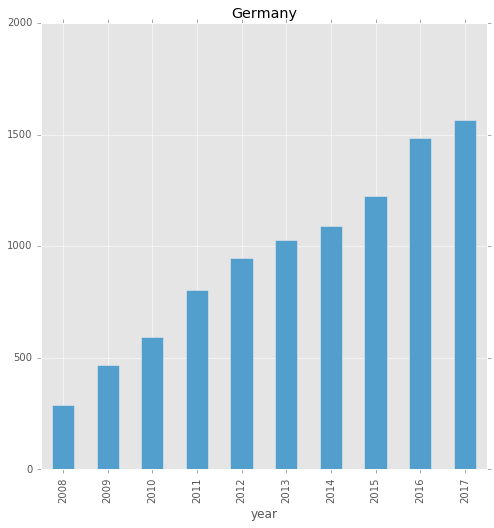

In [35]:
ax = df_financeGermany.plot(kind='bar', figsize =(8,8), color='#529ECD')
ax.set_ylim([0,2000])
plt.title('Germany')
# plt.savefig("Germany.pdf")




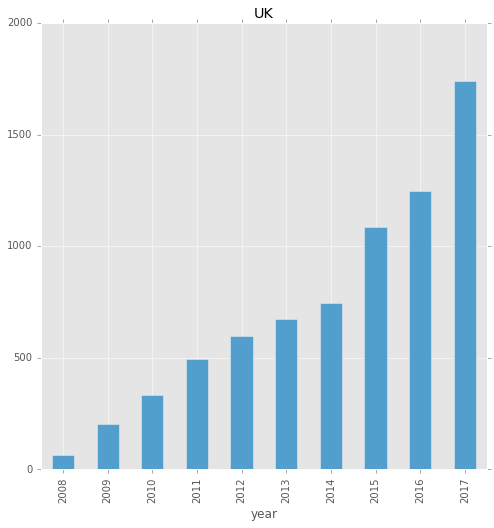

In [36]:
ax = df_financeUK.plot(kind='bar', figsize =(8,8),color='#529ECD')
ax.set_ylim([0,2000])
plt.title('UK')
# plt.savefig("UK.pdf")




In [37]:
# Total number of full time lobbyists per year we calculated pct change between years 2016 - when brexit referendum 
# took place and 2017
df_financeFrance

year
2008     51.0
2009    159.0
2010    192.0
2011    297.0
2012    367.0
2013    418.0
2014    519.0
2015    644.0
2016    760.0
2017    923.0
Name: France, dtype: float64

In [38]:
df_financeGermany

year
2008     290.0
2009     468.0
2010     593.0
2011     802.0
2012     946.0
2013    1028.0
2014    1088.0
2015    1226.0
2016    1485.0
2017    1563.0
Name: Germany, dtype: float64

In [39]:
df_financeUK

year
2008      62.0
2009     202.0
2010     334.0
2011     492.0
2012     596.0
2013     675.0
2014     744.0
2015    1086.0
2016    1249.0
2017    1738.0
Name: United Kingdom, dtype: float64

# Manually found HQs

In [ ]:
# Manually cleaning them up
# To find the headquarters we had to iterate over multiple websites 
# and different wikipedia page, dealing with very different page designs
# Unfortunately there are still companies with empty HQ cells, so we have to find them manually
# Find below all companies manually researched along with the webpage where their HQ was found

# European Commission
# https://ec.europa.eu/info/about-european-commission/organisational-structure/locations_en
    
# Monaco (http://www.gouv.mc/)
# https://www.gouv.mc
    
# DIAVERUM    (http://www.diaverum.com)
# http://www.diaverum.com/ owned by https://en.wikipedia.org/wiki/Bridgepoint_Capital
        
# CEVA (http://www.ceva.nl)
# https://en.wikipedia.org/wiki/CEVA_Logistics

# Japan Business Council in Europe 
# (http://www.jbce.org)

# Mémorial de la Shoah 
# (www.memorialdelashoah.org)

# DROPBOX
# https://en.wikipedia.org/wiki/Dropbox_(service)

# Japan Machinery Center Trade & Investment 
# (http://www.jmcti.org/jmchomepage/english)

# Technicolor SAP (http://www.technicolor.com)
# https://en.wikipedia.org/wiki/Technicolor_SA

    
# EUROPEAN FUEL OXYGENATES ASSOCIATION (EFOA)
# http://www.efoa.eu/en/contact-us.aspx
    
# Mission of Japan to the European Union 
# (http://www.eu.emb-japan.go.jp/itprtop_en/index.html)

# FORUM OF EUROPEAN ASSET MANAGERS (FEAM)
# http://ec.europa.eu/internal_market/investment/docs/consultations/comments/forumofeuropeanassetmanagerfeam.pdf
    
# Springer Science + Business Media Deutschland 
# https://en.wikipedia.org/wiki/Holtzbrinck_Publishing_Group
    
# Ericsson (https://www.ericsson.com/en)
# https://en.wikipedia.org/wiki/Ericsson
    
# Airbus Group (http://www.airbus.com)
# https://en.wikipedia.org/wiki/Airbus
    
# INTERNATIONAL SECURITIES LENDING ASSOCIATION (ISLA)
# https://en.wikipedia.org/wiki/International_Securities_Lending_Association

# MEDEL - UNCLEAR POSSIBLY FRANCE
# https://en.wikipedia.org/wiki/Magistrats_Européens_pour_la_Démocratie_et_les_Libertés

# NIS
# https://corporateeurope.org/sites/default/files/attachments/the_climate_smokescreen_04.pdf
    
# CARLYLE
# https://en.wikipedia.org/wiki/The_Carlyle_Group

# CEMBUREAU
# https://cembureau.eu
    
# CFA INSTITUTE
# https://en.wikipedia.org/wiki/CFA_Institute
    
# CHI-X (BATS)
# https://en.wikipedia.org/wiki/BATS_Chi-X_Europe
    
# EUROPEAN INTERACTIVE DIGITAL ADVERTISING ALLIANCE (EDAA)
# https://www.edaa.eu/about/contact/
    
# EUROPEAN FEDERATION OF PHARMACEUTICAL INDUSTRIES (EFPIA)
# https://www.efpia.eu/contact-us/
    
# ELI LILLY
# https://en.wikipedia.org/wiki/Eli_Lilly_and_Company
    
# EMIRATES
# https://en.wikipedia.org/wiki/Emirates_(airline)
    
# GRODAN
# http://www.grodan.com/contact/
    
# GLODAL SILICONES COUNCIL - Unclear
# https://sehsc.americanchemistry.com/Socio-Economic-Evaluation-of-the-Global-Silicones-Industry-Europe.pdf
# https://www.linkedin.com/in/karluss-thomas-33ab169/
    
# EUROPEAN DIISOCYANATE & POLYOL PRODUCERS ASSOCIATION (ISOPA)
# http://www.isopa.org/contact-us/
    
# MATRIX/STRADA - UNCLEAR

# PRIME COLLATERALISED SECURITIES (PCS)
# http://pcsmarket.org
    
# EUROPEAN CHEMICAL INDUSTRY COUNCIL (CEFIC)
# https://en.wikipedia.org/wiki/European_Chemical_Industry_Council
    
# EUROPEAN INDUSTRIAL GASES ASSOCIATION (EIGA)
# https://de.wikipedia.org/wiki/European_Industrial_Gases_Association
    
# BOSCH
# https://en.wikipedia.org/wiki/Robert_Bosch_GmbH

# BSH
# https://www.bsh-group.com
    
# COMITÉ EUROPÉEN DE FABRICANT DE SUCRE (CEFS)
# https://cefs.org
    
# COSMETICS EUROPE
# https://www.google.com/search?client=safari&rls=en&q=COSMETICS+EUROPE&ie=UTF-8&oe=UTF-8
    
# EWABA
# http://www.ewaba.eu/about-us/
    
# FUELS ETHER - UNCLEAR

# FUELS EUROPE
# https://www.fuelseurope.eu/about-us/contact-us/
    
# Heinemann
# https://en.wikipedia.org/wiki/Heinemann_(publisher)
    
# HG CAPITAL
# https://www.hgcapitaltrust.com
    
# PUEurope
# https://www.pu-europe.eu/contact-us/
    
# WILEY
# https://en.wikipedia.org/wiki/John_Wiley_%26_Sons
    
# CHATHAM FIN
# https://www.chathamfinancial.com/contact/
    
# CONVERGYS
# https://www.convergys.com/index.php
    
# EUROPEAN ALUMINIUM
# https://www.european-aluminium.eu/

    
# JA EUROPE ICEE
# http://www.jaeurope.org/education/initiatives/41-innovation-cluster-for-entrepreneurship-education.html
    
# MEDTECH
# http://fleishmanhillard.eu/work/medtech-europe-telling-patient-story-demonstrate-value/
# http://www.medtecheurope.org/contact-page
    
# PEARSON
# https://en.wikipedia.org/wiki/Pearson_plc

# SYMPHONY ENVIRONMENTAL LTD
# https://www.symphonyenvironmental.com/contact/
    
# UNPRI - UNCLEAR - UN

# TITANIUM DIOXIDE MANUFACTURERS ASSOCIATION (TDMA)
# https://tdma.info/contact-us/
    
# DANONE ELN
# https://en.wikipedia.org/wiki/Danone
    
# EUROPEAN CROP PROTECTION ASSOCIATION (ECPA)
# https://www.ecpa.eu
    
# EUSALT
# https://eusalt.com
    
# EUROPEAN TECH ALLIANCE (EUTA)
# http://eutechalliance.eu/?page_id=16744
    
# FORMACARE
# http://www.formacare.org/about-formacare/contact-us/
    
# GAS NATURALLY
# https://www.gasnaturally.eu/membership
    
# HUDSON TRADING
# https://en.wikipedia.org/wiki/Hudson_River_Trading

# QUANTLAB
# https://www.bloomberg.com/research/stocks/private/snapshot.asp?privcapId=23925728
    
# UNESDA
# https://www.unesda.eu
    
# COGEN
# https://en.wikipedia.org/wiki/COGEN_Europe
    
# The European Society of Cardiology
# https://www.escardio.org
    
# Astana EXPO 2017
# https://en.wikipedia.org/wiki/Expo_2017
    
# Styrenics Steering Committee
# https://polystyreneloop.org/content/8-downloads/presentations/04-plastics-strategy-for-the-styrenics-value-chain.pdf
# https://www.plasticseurope.org/en
    
# DeLaval
# http://www.delavalcorporate.com/contact-delaval/
    
# MSD Europe Inc
# https://lobbyfacts.eu/representative/72831ef0fd6d4637baf281f9e50dd6fc/msd-europe-inc-merck-sharp-dohme
    
# EU MANCOZEB TASK FORCE
# https://lobbyfacts.eu/representative/8dc5495cf9cb45d7a4da956893189274/european-mancozeb-task-force
    
# BDZV
# https://de.wikipedia.org/wiki/Bundesverband_Deutscher_Zeitungsverleger
    
# BROMINE SCIENCE AND ENVIRONMENTAL FORUM
# https://lobbyfacts.eu/representative/a618499ed8f2464795f9c7cb89b0731f
# http://www.bsef.com/about-us/
    
# ACETO Corporation
# http://www.aceto.com/locations.html
    
# CERTIS EUROPE B.V.
# https://www.certiseurope.com/our-company/structure/

# FairSearch
# https://en.wikipedia.org/wiki/FairSearch
    
# Sustainable Eel Group
# https://www.sustainableeelgroup.org
    
# Anchorage
# http://www.anchoragecapital.com.au
    
# EUROPEAN COOL ROOFS COUNCIL (ECRC)
# http://coolroofcouncil.eu/contactus.php
    
# PVCMED
# https://pvcmed.org/contact/
    
# The Health Policy Partnership Ltd
# https://www.healthpolicypartnership.com/contact-us/
    
# European Federation of Precision Mechanical & Optical Indutry
# http://eurom.org/contact/
    
# FECC
# https://www.fecc.org/contact-us
    
# Leclerc
# https://en.wikipedia.org/wiki/E.Leclerc
    
# Free Fair Postal Initiative - FFPI
# https://lobbyfacts.eu/representative/d071cc92cd024bdd9c28f7111dfc2e99/free-fair-post-initiative

# European Chronic Disease Alliance
# http://www.alliancechronicdiseases.org/contact-us/
    
# European Small Volume Car Manufactures Association
# http://www.esca-online.eu/contact-us/
    
# ISACA
# https://en.wikipedia.org/wiki/ISACA
    
# Project Management Institute - PMI
# https://www.pmi.org
    
# European Academy of Allergy & Clinical Immunology
# https://en.wikipedia.org/wiki/European_Academy_of_Allergy_and_Clinical_Immunology
    
# Expedia
# https://en.wikipedia.org/wiki/Expedia

# Sony Computer Entertainment Europe
# https://en.wikipedia.org/wiki/Sony_Interactive_Entertainment
    
# European Carton Makers Association
# https://www.ecma.org/contact/
    
# The Optical Society
# https://en.wikipedia.org/wiki/The_Optical_Society
    
# ISPO
# https://en.wikipedia.org/wiki/Internationale_Fachmesse_für_Sportartikel_und_Sportmode
    
# Institute of Electrical & Electronics Engineers - IEEE
# https://en.wikipedia.org/wiki/Institute_of_Electrical_and_Electronics_Engineers
    
# European Alliance for Personalised Medecine
# https://euapm.eu
    
# European Society for Radiotherapy & Oncology
# https://www.estro.org/about-us/contacts
    
# CEFIC aisbl
# http://www.cefic.org/About-us/How-to-reach-us-/
    
# Fuels Europe
# https://www.fuelseurope.eu/about-us/contact-us/
    
# MSD Europe Inc
# https://lobbyfacts.eu/representative/72831ef0fd6d4637baf281f9e50dd6fc/msd-europe-inc-merck-sharp-dohme
    
# European Federation of Parquet Importers - EFPI
# https://uia.org/s/or/en/1100068038
    
# Orphan Europe
# http://www.orphan-europe.com
    
# SFEE
# https://www.sfee.gr/?lang=en
    
# DSM
# https://www.dsm.com/corporate/home.html
    
# Hilton
# https://en.wikipedia.org/wiki/Hilton_Hotels_%26_Resorts
    
# The Global Business Travel Association
# https://www.gbta.org
    
# Transfrigoroute International
# http://www.transfrigo.com
    
# The Electric Underfloor Heating Alliance - EUHA
# https://euha-alliance.eu/contact/
    
# spiritsEUROPE
# https://spirits.eu/about-us/contact
    
# The European Federation of Pharmaceutical Industries and Associations (EFPIA)
# https://www.efpia.eu/contact-us/
    
# PayU
# https://en.wikipedia.org/wiki/PayU
    
# The European Ventilation Industry Association
# https://www.evia.eu/contact/
    
# UNESDA
# https://www.unesda.eu/contact/
    
# Specialised Nutrition Europe (SNE)
# http://www.specialisednutritioneurope.eu/contact-us
    
# European Partnership for Energy and the Environment
# https://www.epeeglobal.org
    
# Agicoa
# https://www.agicoa.org/english/contact.html
    
# European Contact Group
# https://lobbyfacts.eu/representative/29e5ac4f17074dd4ac4500731d5a9191/european-contact-group
    
# Renson NV
# http://renson.us/contact-united-states.html
    
# Starch Europe
# https://www.starch.eu/contact/
    
# European Round Table of Industrialists
# https://www.ert.eu/contact
    
# Oral Health Platform
# http://www.oralhealthplatform.eu/contact/

# Trade Secrets and Innovation Coalition
# https://lobbyfacts.eu/representative/e948772a4b104fc292565ecf7e106735/trade-secrets-innovation-coalition
    
# Anitox Ltd
# https://www.anitox.com/who-we-are/
    
# European Lime Association
# https://www.eula.eu/about-us
    
# Europe Natural Soyfood Manufacturers
# http://www.ensa-eu.org
    
# European State Lotteries and Toto Association
# https://www.european-lotteries.org
    
# Isabel NV
# https://www.isabelgroup.eu/en/about-us/
    
# MSD (Europe) Inc.
# https://lobbyfacts.eu/representative/72831ef0fd6d4637baf281f9e50dd6fc/msd-europe-inc-merck-sharp-dohme
    
# Business Alliance TTIP
# UNCLEAr

# European Art Market Coalition
# https://lobbyfacts.eu/representative/2db7f07952b24783afcb4e4bbeb02a21/european-art-market-coalition
    
# Anti Cancer Fund
# https://www.anticancerfund.org/en/contact
    
# Frontiers
# https://en.wikipedia.org/wiki/Frontiers_Media
    
# Astellas
# https://en.wikipedia.org/wiki/Astellas_Pharma
    
# EAACI
# http://www.eaaci.org/contact-top.html
    
# FRE - UNCLEAR
# https://www.linkedin.com/company/fre-inc/

# European Biodiesel Board
# http://www.ebb-eu.org

# European Federation of Periodontology
# https://www.facebook.com/EFP.org
    
# FEDIEX SCRL
# https://trendstop.levif.be/fr/detail/403031040/fediex.aspx
    
# Koninklijke Bunge B.V.
# https://www.bloomberg.com/research/stocks/private/snapshot.asp?privcapId=5489580
    
# Nestlé Nespresso S.A.
# https://en.wikipedia.org/wiki/Nespresso
    
# La Mission du Royaume du Maroc
# http://europa.eu/whoiswho/public/index.cfm?fuseaction=idea.hierarchy&nodeID=65886&lang=fr
    
# Pancreatic Cancer Europe
# https://www.pancreaticcancereurope.eu/contact/
    
# Doc Morris
# https://de.wikipedia.org/wiki/DocMorris
    
# Alpha-1 Global
# http://alpha-1global.org/en/about-us/
    
# Drone Alliance Europe
# https://lobbyfacts.eu/representative/a376276164204f3bbc45d50cb5a4daec/drone-alliance-europe
    
# Estée Lauder
# https://en.wikipedia.org/wiki/Estée_Lauder_Companies
    
# Medical Nutrition Industry
# https://medicalnutritionindustry.com/contact/
    
# ePURE - European Renewable Ethanol
# https://www.epure.org/contact-us/
    
# Children's Investment Fund Foundation
# https://en.wikipedia.org/wiki/The_Children%27s_Investment_Fund_Foundation
    
# Erasmus University Medical Center
# https://en.wikipedia.org/wiki/Erasmus_MC
    
# European Federation of Pharmaceutical Industries and Associations
# https://www.efpia.eu/contact-us/
    
# NPE
# http://www.npe.org/contact-us
    
# European Autoclaved Aerated Concrete Association
# https://www.eaaca.org/index.php/contact
    
# Orange
# https://en.wikipedia.org/wiki/Orange_S.A.
    
# Figiefa
# https://www.figiefa.eu/who-we-are/
    
# PhRMA
# https://en.wikipedia.org/wiki/Pharmaceutical_Research_and_Manufacturers_of_America
    
# Zero Emission Platfrom
# https://twitter.com/EUCarbonCapture
    
# European Idiopathic Pulmonary Fibrosis & Related Disorders Federation
# https://www.eu-ipff.org
    
# UPEI
# http://www.upei.org
    
# Solar Power Europe
# http://www.solarpowereurope.org/contact-us/
    
# Brains for Brain Foundation
# UNCLEAR

# Pann-Nordic Card Association
# http://www.pan-nordic.org/PanNordicCard/Home/Contact-PNC.aspx
    
# Cranberry Marketing Committee
# http://www.uscranberries.com
    
# Conai
# http://www.conai.org
    
# European Bioplastics
# https://www.european-bioplastics.org/about-us/contact-us/
    
# Instituto Ortopedio Rizzoli
# http://www.ior.it
    
# Institutional Investors Group for Climate Change
# http://www.iigcc.org/contact-us
    
# Stroke Alliance for Europe
# https://www.safestroke.eu/contact/
    
# Oil Companies International Marine Forum
# https://www.ocimf.org/contact-us.aspx
    
# Extended Producer Responsibility Alliance
# http://www.expra.eu/en/contact
    
# FoodDrinkEurope
# https://www.fooddrinkeurope.eu/about-us/contact-us/
    
# GBH
# UNCLEAR

# eurodom
# http://www.eurodom.org/nous-contacter
    
# CODERUM MARTINIQUE
# https://en.wikipedia.org/wiki/Martinique
    
# COFEPP
# https://www.thespiritsbusiness.com/tag/cofepp/
    
# ASPROCAN
# https://platanodecanarias.net/contacto/
    
# UNION DES GROUPEMENT
# https://www.societe.com/societe/syndicat-des-rhumiers-independants-de-la-guadeloupe-503223133.html
    
# Tipik
# https://www.tipik.eu/contact/
    
# EQUAL - UNCLEAR

# CNPA
# https://cnpa.com/about/
    
# VIN ET SOCIETE
# http://www.vinetsociete.fr/contactez-nous
    
# HEETCH
# https://fr.wikipedia.org/wiki/Heetch

# ETAF
# https://www.etaf.tax
    
# SEIU
# http://www.seiu.org/about
    
# COMITE FRANCECLAT
# http://www.franceclat.fr/contact.html
    
# ANIFELT
# https://lobbyfacts.eu/representative/c5691a004bf64118be470b12ec26f389/association-nationale-interprofessionnelle-des-fruits-et-legumes-transformes

# CSO
# https://www.csoonline.com/about/contactus.html
    
# SMAVA
# https://www.crunchbase.com/organization/smava#section-overview
    
# AUTHENTIFIER.COM
# https://www.facebook.com/authentifiercom-170990939747577/
    
# IPD
# http://ipdcompany.com
    
# DYNAMO
# https://dynamotechnologies.com/contact/
    
# EFFCI
# http://effci.com/?pge=contact
    
# ETAI
# https://www.bloomberg.com/research/stocks/private/snapshot.asp?privcapid=25107466
    
# FIVAPE
# https://www.fivape.org/presentation/
    
# Heineken
# https://en.wikipedia.org/wiki/Heineken
    
# Ligue de Football Professionnel
# https://en.wikipedia.org/wiki/Ligue_de_Football_Professionnel
    
# Association Européenne des Audioprothésistes
# https://www.aea-audio.org/portal/index.php/aea-statute
    
# Specialty Equipment Market Association
# https://en.wikipedia.org/wiki/SEMA
    
# Specialty Equipment Market Association
# https://www.sema.org/press?__utma=95790915.799278972.1537786594.1537786667.1537786667.1&__utmb=95790915.0.10.1537786667&__utmc=95790915&__utmx=-&__utmz=95790915.1537786667.1.1.utmcsr=google|utmccn=(organic)|utmcmd=organic|utmctr=(not%20provided)&__utmv=-&__utmk=232078167
    
# Euro-Toques International
# https://de.wikipedia.org/wiki/Euro-Toques
    
# Auchan Hongrie
# https://export.businessfrance.fr/hongrie/001B1803847A+hongrie-auchan-hongrie-inaugurera-son-immense-centre-logistique-a-la-fin-d-an.html

# ACTA
# https://lobbyfacts.eu/representative/1a956cd96db047c18446bf949d7fdde0/acta-les-instituts-techniques-agricoles
    
# MAIF
# https://fr.wikipedia.org/wiki/Mutuelle_d%27assurance_des_instituteurs_de_France
    
# Ecofolio
# https://www.ecofolio.fr
    
# Comité du Pineau des charentes
# https://www.pineau.fr/en/find-us
    
# UEVP - Union européenne des Vétérinaires Praticiens
# http://www.vet.ee/docs/Yldinfo/08_015_ga_draft_4.pdf
    
# NFID - Nord France Innovation Développement
# http://www.hautsdefrance-id.fr/contact/
    
# EUCOPRO
# https://lobbyfacts.eu/representative/5362307374b14e2db6b3669678775369/european-co-processing-association
    
# EUF - European Association for the Factoring and Commercial Finance Industry
# https://euf.eu.com/eu-federation.html
    
# CNOMK - Conseil National de l'Ordre des Masseurs-kinésithérapeutes
# http://www.ordremk.fr/ordre/nous-contacter/
    
# European Compost Network
# https://lobbyfacts.eu/representative/6e842d6fadfd4573896f408201ee26ff/european-compost-network-ecn-e-v
    
# Eurofuel
# https://www.eurofuel.eu/contact
    
# Hepatitis B&C Public Policy Association
# http://www.hepbcppa.org/contact/
    
# Wiley
# https://en.wikipedia.org/wiki/John_Wiley_%26_Sons
    
# Tamro Eesti OÜ
# https://www.tamrobaltics.com/contacts/headquarters
    
# Nickel Institute
# https://www.nickelinstitute.org/AboutUs/ContactUs
    
# European Branded Clothing Alliance
# http://www.ebca-europe.org/contact.html
    
# Metal Packaging Europe
# http://www.metalpackagingeurope.org/about
    
# Sky
# https://en.wikipedia.org/wiki/Sky_plc
    
# Vaccines Europe
# https://www.vaccineseurope.eu/contact/

# DIAVERUM    (http://www.diaverum.com)
# https://www.diaverum.com/corp/Corporate-Menu/Contact/